# 概要
- 101クラス分類
- 対象：料理画像
- VGG16による転移学習
    1. 全結合層
    1. 全層
- RXなし

In [1]:
RUN = 100

# 使用するGPUメモリの制限

In [2]:
import tensorflow as tf

tf_ver = tf.__version__

if tf_ver.startswith('1.'):
    from tensorflow.keras.backend import set_session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.log_device_placement = True
    sess = tf.Session(config=config)
    set_session(sess)

# 使用するGPUを指定

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

# matplotlibでプロットしたグラフをファイルへ保存

In [4]:
import os
def save_fig(plt, file_prefix):
    if file_prefix == '':
        return
    
    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0)

# 指定フォルダ以下にある画像リストを作成
- サブフォルダはラベルに対応する数字であること
- TOP_DIR
  - 0
    - 00001.jpg
    - 00002.jpg
  - 1
    - 00003.jpg
    - 00004.jpg

In [5]:
import pathlib
import random
import os

TOP_DIR = '/data1/Datasets/Food-101/03_all'

sub_dirs = pathlib.Path(TOP_DIR).glob('*/**')

label2files = dict()
for s in sub_dirs:
    files = pathlib.Path(s).glob('**/*.jpg')
    label = int(os.path.basename(s))
    label2files[label] = list(files)

# 画像とラベルを訓練データと検証データに分割する

In [6]:
ratio = 0.8
train_list = []
train_labels = []

val_list = []
val_labels = []

for k, v in label2files.items():
    random.shuffle(v)
    N = len(v)
    N_train = int(N * ratio)
    train_list.extend(v[:N_train])
    train_labels.extend([k] * N_train)
    
    val_list.extend(v[N_train:])
    val_labels.extend([k] * (N - N_train))
    
NUM_CLASSES = len(label2files.keys())

# 画像ファイルリストとラベルから教師データを生成するクラス

In [7]:
import math
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

class ImageSequence(tf.keras.utils.Sequence):
    def __init__(self, file_list, labels, batch_size, image_shape=(224, 224), shuffle=True, horizontal_flip=True):
        self.file_list = np.array(file_list)
        self.labels = to_categorical(labels)
        self.batch_size = batch_size
        self.image_shape = image_shape
        self.shuffle = shuffle
        self.horizontal_flip = horizontal_flip
        
        self.indexes = np.arange(len(self.file_list))
        if self.shuffle:
            random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        idx = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        y = self.labels[idx]
        
        files = self.file_list[idx]

        x = []
        for f in files:
            try:
                img = Image.open(f)
                
                # 正しいデータはRGB画像
                # データセットの中には、グレースケール画像が入っている可能性がある。
                # RGBに変換して、正しいデータと次元を揃える
                img = img.convert('RGB')
                img = img.resize(self.image_shape, Image.BILINEAR)
                img = img_to_array(img)
                img = preprocess_input(img) / 255.0
                if self.horizontal_flip and np.random.random() > 0.5:
                    img = img[:,::-1, :]
                    
                x.append(np.expand_dims(img, axis=0))
            except:
                print(f)
        return np.concatenate(x, axis=0), y
    
    def __len__(self):
        return len(self.file_list) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.indexes)

Using TensorFlow backend.


# モデル保存用のディレクトリを作成★

In [8]:
import os
from datetime import datetime

# モデル保存用ディレクトリの準備
model_dir = os.path.join(
    f'../run/VGG16_run{RUN}'
)
os.makedirs(model_dir, exist_ok=True)
print('model_dir:', model_dir)  # 保存先のディレクトリ名を表示

dir_weights = model_dir
os.makedirs(dir_weights, exist_ok=True)

model_dir: ../run/VGG16_run100


# VGGモデルのロード

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16


# 既存の1000クラスの出力を使わないため、
# `incliude_top=False`として出力層を含まない状態でロード
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3))

# モデルのサマリを確認。出力層が含まれてないことがわかる
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# VGG16を利用したモデルの作成と学習方法の設定★

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten


# モデルを編集し、ネットワークを生成する関数の定義
def build_transfer_model(vgg16):
    
    # 読み出したモデルを使って、新しいモデルを作成
    model = Sequential(vgg16.layers)

    # 読み出した重みの一部は再学習しないように設定。
    # ここでは、追加する層と出力層に近い層の重みのみを再学習
    for layer in model.layers[:15]:
        layer.trainable = False
        
    # 追加する出力部分の層を構築
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

# 全結合層とそれに近い畳み込み層の学習★

## モデル作成

In [11]:
# 定義した関数を呼び出して、ネットワークを生成
model = build_transfer_model(vgg16)

## ネットワーク構造の保存★

In [12]:
import json
import pickle

# ネットワークの保存
model_json = os.path.join(model_dir, 'model.json')
with open(model_json, 'w') as f:
    json.dump(model.to_json(), f)

## 最適化アルゴリズムなどを指定してモデルをコンパイルする

In [13]:
from tensorflow.keras.optimizers import SGD


model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

In [14]:
# モデルのサマリを確認
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## シーケンス生成

In [15]:
batch_size = 25

img_seq_train = ImageSequence(train_list, train_labels, batch_size=batch_size)

img_seq_validation = ImageSequence(val_list, val_labels, batch_size=batch_size)

print('Train images =', len(img_seq_train) * batch_size)
print('Validation images =', len(img_seq_validation) * batch_size)

Train images = 80800
Validation images = 20200


## Callbackの生成★

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


# Callbacksの設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:04d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='val_acc', 
                     verbose=0,
                     save_best_only=True, 
                     save_weights_only=True, 
                     mode='auto'
                     )

csv_filepath =  os.path.join(model_dir, 'loss.csv')
csv = CSVLogger(csv_filepath, append=True)

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

## 学習

In [17]:
n_epoch = 200

# モデルの学習
history = model.fit_generator(
    img_seq_train, 
    epochs=n_epoch,  # 学習するエポック数
    steps_per_epoch=len(img_seq_train),
    validation_data=img_seq_validation,
    validation_steps=len(img_seq_validation),
    verbose=1,
    callbacks=[cp, csv, es, rl]
)

Epoch 1/200
3232/3232 [==============================] - 1217s 377ms/step - loss: 4.6143 - acc: 0.0148 - val_loss: 4.5334 - val_acc: 0.0410
Epoch 2/200
3232/3232 [==============================] - 499s 155ms/step - loss: 4.4336 - acc: 0.0381 - val_loss: 4.0951 - val_acc: 0.1068
Epoch 3/200
3232/3232 [==============================] - 500s 155ms/step - loss: 4.0705 - acc: 0.0861 - val_loss: 3.5528 - val_acc: 0.2125
Epoch 4/200
3232/3232 [==============================] - 499s 154ms/step - loss: 3.6836 - acc: 0.1451 - val_loss: 3.1393 - val_acc: 0.2758
Epoch 5/200
3232/3232 [==============================] - 502s 155ms/step - loss: 3.3705 - acc: 0.2016 - val_loss: 2.8485 - val_acc: 0.3291
Epoch 6/200
3232/3232 [==============================] - 508s 157ms/step - loss: 3.1329 - acc: 0.2452 - val_loss: 2.6545 - val_acc: 0.3693
Epoch 7/200
3232/3232 [==============================] - 500s 155ms/step - loss: 2.9475 - acc: 0.2812 - val_loss: 2.5029 - val_acc: 0.3941
Epoch 8/200
3232/3232 [===

## Stage1の損失と正解率の保存

In [18]:
h = history.history

stage1_loss = h['loss']
stage1_val_loss = h['val_loss']

stage1_acc = h['acc']
stage1_val_acc = h['val_acc']

# 全層の学習

## Stage1の最良モデルパラメータをロード

In [19]:
import pathlib

checkpoints = pathlib.Path(model_dir).glob('*.h5')
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)

latest = str(checkpoints[-1])
model.load_weights(latest)

## 全層を学習可能にする

In [20]:
for l in model.layers:
    l.trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

## 最適化アルゴリズムなどを指定してモデルをコンパイルする

In [21]:
from tensorflow.keras.optimizers import SGD

model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr=1e-4, momentum=0.9),
    metrics=['accuracy']
)

## シーケンス生成

In [22]:
batch_size = 25

img_seq_train = ImageSequence(train_list, train_labels, batch_size=batch_size)

img_seq_validation = ImageSequence(val_list, val_labels, batch_size=batch_size)

print('Train images =', len(img_seq_train) * batch_size)
print('Validation images =', len(img_seq_validation) * batch_size)

Train images = 80800
Validation images = 20200


## Callbackの生成★

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau


# Callbacksの設定
cp_filepath =  os.path.join(dir_weights, 'ep_{epoch:04d}_ls_{loss:.1f}.h5')
cp = ModelCheckpoint(
                     cp_filepath, 
                     monitor='val_acc', 
                     verbose=0,
                     save_best_only=True, 
                     save_weights_only=True, 
                     mode='auto'
                     )

csv_filepath =  os.path.join(model_dir, 'stage2_loss.csv')
csv = CSVLogger(csv_filepath, append=True)

es = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='auto')

rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0)

## 学習

In [24]:
n_epoch = 500
initial_epoch = len(stage1_loss)

# モデルの学習
history = model.fit_generator(
    img_seq_train, 
    epochs=n_epoch,  # 学習するエポック数
    steps_per_epoch=len(img_seq_train),
    validation_data=img_seq_validation,
    validation_steps=len(img_seq_validation),
    verbose=1,
    callbacks=[cp, csv, es, rl],
    initial_epoch=initial_epoch
)

Epoch 113/500
3232/3232 [==============================] - 800s 247ms/step - loss: 1.0005 - acc: 0.7156 - val_loss: 1.5914 - val_acc: 0.6010
Epoch 114/500
3232/3232 [==============================] - 797s 247ms/step - loss: 0.8781 - acc: 0.7448 - val_loss: 1.5427 - val_acc: 0.6180
Epoch 115/500
3232/3232 [==============================] - 797s 247ms/step - loss: 0.8167 - acc: 0.7629 - val_loss: 1.5274 - val_acc: 0.6247
Epoch 116/500
3232/3232 [==============================] - 798s 247ms/step - loss: 0.7525 - acc: 0.7781 - val_loss: 1.5708 - val_acc: 0.6297
Epoch 117/500
3232/3232 [==============================] - 797s 247ms/step - loss: 0.7048 - acc: 0.7932 - val_loss: 1.5540 - val_acc: 0.6318
Epoch 118/500
3232/3232 [==============================] - 797s 247ms/step - loss: 0.6641 - acc: 0.8020 - val_loss: 1.5949 - val_acc: 0.6291
Epoch 119/500
3232/3232 [==============================] - 797s 247ms/step - loss: 0.6321 - acc: 0.8123 - val_loss: 1.6130 - val_acc: 0.6234
Epoch 120/500

# 結果

## 損失関数のプロット

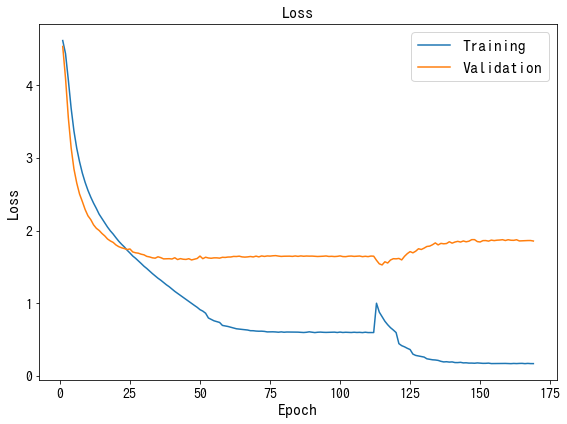

In [25]:
plt.figure(figsize=(8, 6))
h = history.history

loss = stage1_loss + h['loss']
val_loss = stage1_val_loss + h['val_loss']
ep = np.arange(1, len(loss) + 1)
plt.title('Loss', fontsize=16)
plt.plot(ep, loss, label='Training')
plt.plot(ep, val_loss, label='Validation')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.tight_layout()
save_fig(plt, file_prefix=os.path.join(model_dir, 'Loss'))
plt.show()

## 正解率のプロット

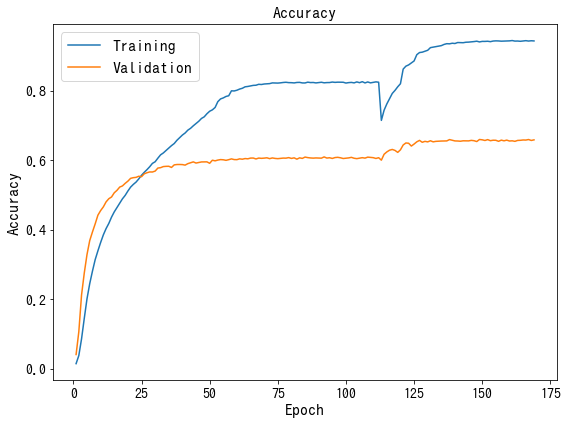

In [26]:
plt.figure(figsize=(8, 6))
h = history.history

acc = stage1_acc + h['acc']
val_acc = stage1_val_acc + h['val_acc']
ep = np.arange(1, len(loss) + 1)
plt.title('Accuracy', fontsize=16)
plt.plot(ep, acc, label='Training')
plt.plot(ep, val_acc, label='Validation')
plt.legend(fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.tight_layout()
save_fig(plt, file_prefix=os.path.join(model_dir, 'Loss'))
plt.show()

## 汎化能力の推定

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evalulate(y_true, y_pred, file_prefix=''):
    
    cm = confusion_matrix(y_true, y_pred)
#     print(cm)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy}')
    
    class_labels = []
    for i in range(y_true.max() + 1):
        class_labels.append(f'{i:4d}')
    
    precision_str = []
    recall_str = []
    for i in range(y_true.max() + 1):
        precision_str.append(f'{precision[i]}')
        recall_str.append(f'{recall[i]}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))
                             
    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

正解率
 0.6573267326732674
精度
    0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79   80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95   96   97   98   99  100
 0.38235294117647056 0.6367713004484304 0.6298076923076923 0.7309644670050761 0.5566037735849056 0.5891089108910891 0.797979797979798 0.803030303030303 0.45251396648044695 0.505 0.543010752688172 0.7149532710280374 0.7486631016042781 0.6633663366336634 0.5778894472361809 0.44559585492227977 0.5807860262008734 0.5285714285714286 0.5314285714285715 0.6101694915254238 0.6730769230769231 0.5431034482758621 0.4878048780487805 0.7323232323232324 0.6651376146788991 0.73

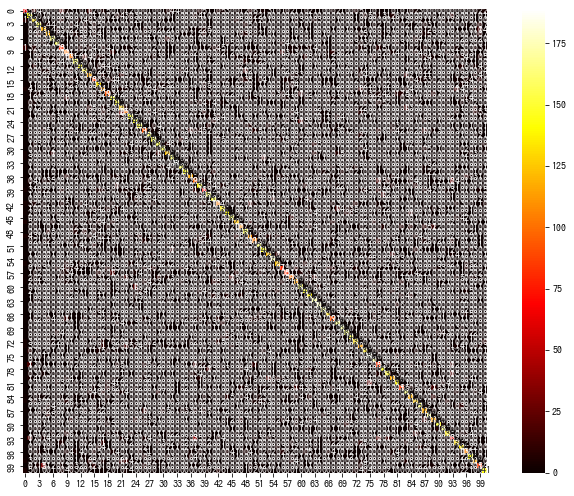

In [29]:
import pathlib

checkpoints = pathlib.Path(model_dir).glob('*.h5')
checkpoints = sorted(checkpoints, key=lambda cp:cp.stat().st_mtime)

latest = str(checkpoints[-1])
model.load_weights(latest)

batch_size = 25
img_seq_validation = ImageSequence(val_list, val_labels, shuffle=False, batch_size=batch_size)

y_pred = model.predict_generator(img_seq_validation)
y_pred_classes = y_pred.argmax(axis=1)
y_true = np.array(val_labels)
evalulate(y_true, y_pred_classes, file_prefix=os.path.join(model_dir, 'cm'))